# Introduction to Prophet
## A time series forecasting library

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from prophet import Prophet

# %matplotlib inline

## Introduction to Forecasting

**Forecasting** is a fundamental data science task. Accurate forecasting is crucial when planning and allocating resources, setting goals and detecting anomalies.

However, building reliable and robust forecasting models is **challenging** and often requires **expert input**. For example, there may be holidays or other 'one-off' effects that need to be taken in consideration for accurate forecasts.

## Introduction to Prophet

- Open source python module developed by Facebook
- Easy-to-use library for time series forecasting
- Allows to explicitly model the linear, seasonal components

## Aims of this session

* Introduce Prophet library
* Overview time series forecasting 
* Provide a practical understanding of how the Prophet library works and the intuition behind it.
* Demonstrate how to use Prophet to explore datasets.

In this learning unit we will provide an overview about forecasting and discuss how to quickly implement your own forecast using the Prophet package. It was recently released by Facebook Core Data Science team. The Prophet package fits an easily interpretable regression model which can account for seasonality trends (e.g., yearly or weekly effects) and holiday effects.

## Dataset: TFL Daily Cycle Hires

In this learning unit, we introduce a new **open access TFL dataset**. 
The dataset corresponds to the total number of daily hires for Santander bikes over a period of approximately seven years.

The dataset can be downloaded from the following website:

https://data.london.gov.uk/dataset/number-bicycle-hires

Throughout this learning unit we will be using an **open access TFL dataset** relating to the number of TFL cycles borrowed over a period of several years. 

This dataset will demonstrate considerable season effects (for example there are yearly seasonal effects as customers are likely to cycle in the summer) as well as and holiday effects (in particular, we will study the effects of bank holidays and the tube strike on the number of bikes borrowed!).

Before discussing the details of the prophet package, we provide an exploratory overview of the dataset.

Below are **the first 10 entries** of the dataset:

In [2]:
df_data = pd.read_excel("data/tfl-daily-cycle-hires.xls", sheet_name="Data")
df_data = df_data[["Day", "Number of Bicycle Hires"]]
df_data["Day"] = df_data["Day"].dt.date
df_data.head(10).T

,0,1,2,3,4,5,6,7,8,9
Day,2010-07-30,2010-07-31,2010-08-01,2010-08-02,2010-08-03,2010-08-04,2010-08-05,2010-08-06,2010-08-07,2010-08-08
Number of Bicycle Hires,6897,5564,4303,6642,7966,7893,8724,9797,6631,7864


And **the last 10 entries** of the dataset:

In [3]:
df_data.tail(10).T

,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954
Day,2018-08-22,2018-08-23,2018-08-24,2018-08-25,2018-08-26,2018-08-27,2018-08-28,2018-08-29,2018-08-30,2018-08-31
Number of Bicycle Hires,38401,34492,27839,25490,8177,25059,34791,27070,37001,35209


## Exploratory analysis

Exploring the basic statistics about the Number of Bicycle Hires

In [4]:
df_data.describe()

,Number of Bicycle Hires
count,2955.000000
mean,25309.988494
std,9304.005522
min,2764.000000
25%,18794.000000
50%,24989.000000
75%,31958.500000
max,73094.000000


## Exploratory analysis

Plotting the **time series** of the Number of Bicycle Hires over time:

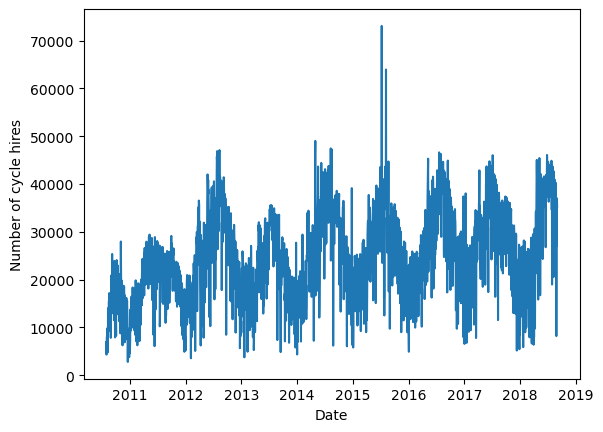

In [5]:
plt.plot(df_data["Day"], df_data["Number of Bicycle Hires"])
plt.xlabel("Date")
plt.ylabel("Number of cycle hires")
plt.show()

From the figure above (of daily bike hires) we see several clear effects which are often present in forecasting challenges:

* Seasonality: There is a drop during the winter months and a rise during the summer months. This seasonality is easy to understand but needs to be accounted for in order to obtain reliable forecasts.
* Trends: There is a slight, overall upward trend. This means that the number of cycles hired has increased over time. 
* Outliers: There are obvious outliers, notably during the summer of 2015. This coincides with the tube strike, which foreced commuters to find alternative routes. The histogram plot, shown below, highlights the presence of these large positive outliers. 
 
In the remainder of this tutorial we will introduce the prophet package and demonstrate how it may be used to handle each of the challenges discussed above.

## Exploratory analysis

Plotting the **Histogram** of the Daily Number of Bicycle Hires:

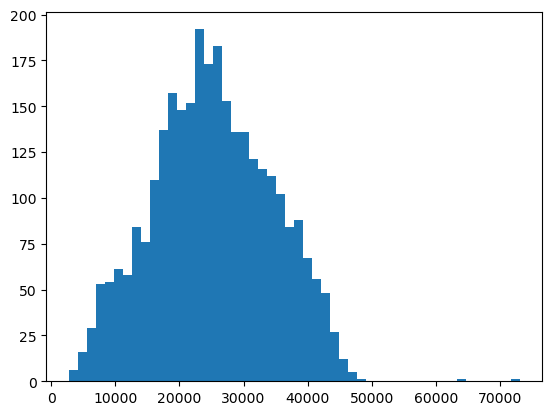

In [6]:
plt.hist((df_data["Number of Bicycle Hires"]), bins=50)
plt.show()

Histrogram of the data to demonstrate there are large positive outliers.
It is important to note that due to the seasonality, there may also be large negative outliers, but we cannot spot them in the histogram below as they are within the range of the data. 

The data appears to be approximately Gaussian, with a few outliers (we discuss these below).
So don't need to transform the data (e.g., via log transform).

## Preparing the data 

Before we begin to use **Prophet library**, we must make sure we prepare the `DataFrame` in a correct format.

The prophet package expects input as a dataframe with **the first column** indicating **time** and **the second  column** indicating **the time series** we wish to forecast.

It also expects these columns to have the names 'ds' and 'y', so we rename them accordingly:

In [7]:
df_data["Day"] = pd.DatetimeIndex(df_data["Day"])
df_data = df_data.rename(columns={"Day": "ds", "Number of Bicycle Hires": "y"})
df_data.head()

,ds,y
0,2010-07-30,6897
1,2010-07-31,5564
2,2010-08-01,4303
3,2010-08-02,6642
4,2010-08-03,7966


## The Prophet model

The idea behind the prophet package is to decompose time series data into the following three components:

- **trends**: these are non-periodic and systematic trends in the data,
- **seasonal effects**: these are modelled as daily or yearly periodicities in the data (optionally also hourly), and
- **holidays/one-off effects**: these are effectively outliers.
 
Each of these components contribute *additively* to the observed time series. In other words, the number of cycle hires on any give day is *the sum* of the trend component, the seasonal component and the one-off effects. As a result, the model can be mathematically written as follows:

$$ y(t) = g(t) + s(t) + h(t) + \epsilon_t $$

where $y(t)$ is the number of cycles hired on day $t$ and $g(t), s(t)$ and $h(t)$ correspond to the growth trend, seasonal effects and holiday effects respectively. Finally, $\epsilon_t$ accounts for noise. 

We note that the approach taken in the Prophet packge is different from traditional forecasting models such as [ARMA](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model) models. For example, note that $y(t)$ is not a function of $y(t-1)$ but instead a function of the growth, season and holiday effects. The main advantages of taking an additive approach are as follows.

- It provides us with more flexibility. For example, we can easily accomodate irregular measurements.
- We can directly interpret each of the additive components and thus untangle the contributions of each aspect to the forecasts. This is important when we look to understand how the data was generated.
 
We now discuss each of the components of the model

### Trend component

The default trend component in the Prophet package is a linear growth trend with some changepoints. If there are no changepoints, this means that the growth with continue to grow at some linear rate such that:

$$ g(t) = \alpha t$$

Changepoints are introduced so that the linear rate of growth can vary.

For example, it may be the case that there was 2% daily growth (corresponding to $g(t) = 1.02 \times t$) for the first year and 1% daily growth (so that $g(t) = 1.01 \times t$) afterwards.

### Seasonal components

Seasonality is a crucial component of many time-series and is clearly present in the TFL data.

The approach in the Prophet package considers various seasonal components with varying periodicities: 

- daily seasonality
- weekly seasonality
- yearly seasonality

For example, we may have one component with a periodicity of 7 days to capture weekly effects, and another with a periodicity of 365 days to capture yearly effects. By default, the Prophet package includes weekly and yearly seasonalities. This is what makes the most sense in this example, but it is also possible to include other seasonalities.

Seasonalities are estimated using a partial Fourier sum. The number of terms in the partial sum (the order) is a parameter that determines how quickly the seasonality can change. The default Fourier order for yearly seasonality is 10.

The default values are often appropriate, but they can be increased when the seasonality needs to fit higher-frequency changes, and generally be less smooth. The Fourier order can be specified for each built-in seasonality when instantiating the model.

### Seasonal components

There is a possibility to specify **Custom Seasonalities** using `add_seasonality` function:

`m = Prophet(weekly_seasonality=False)`

`m.add_seasonality(name='monthly', period=30.5, fourier_order=5)`


It is possible to add other seasonalities (monthly, quarterly, hourly) using the add_seasonality method.

The inputs to this function are a name, the period of the seasonality in days, and the Fourier order for the seasonality. For reference, by default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality. An optional input to add_seasonality is the prior scale for that seasonal component.

For example, we can replace weekly seasonality with monthly seasonality as shown on the slide.

### Holidays/outliers 

The Prophet package directly allows to account for outliers (for example, events such as holidays or strikes) by allowing the user to input a list of days.

In this way prophet accounts for large positive/negative values of holidays or potential outliers.

The presence of outliers is   well-document difficulty with time-series and forecasting data. These are data points which deviate significantly from the distribution of the remainder of the data. If these points are ignored they may possibly lead to poor forecasts and so it is important to consider these points carefully. Recall that in the case of the TFL cycle hire data, there were clear outliers around the time of the 2015 strikes (around the summer of 2015). Other important examples may include holidays or snow days.

## Accounting for one-off effects: 

## Holidays and Tube strikes

Let's add information about holidays and tube strikes to our Prophet model.

Both holidays and tube strikes are one-off effects that can lead to outliers.

To achieve that, we make a separate `DataFrame` with **holidays** and the dates of the  **tube strikes**.

In [8]:
bank_holidays = pd.DataFrame(
    {
        "holiday": "BankHoliday",
        "ds": pd.to_datetime(list(pd.read_csv("data/BankHolidayLists.csv")["Date"])),
    }
)
strike_days = pd.DataFrame(
    {
        "holiday": "strike",
        "ds": pd.to_datetime(
            [
                "2017-08-05",
                "2017-08-06",
                "2017-02-06",
                "2015-07-09",
                "2015-07-08",
                "2015-03-08",
            ]
        ),
    }
)
all_holidays_strikes = pd.concat((bank_holidays, strike_days))
all_holidays_strikes["ds"] = all_holidays_strikes["ds"].dt.date
all_holidays_strikes.tail(n=10).T

,92,93,94,95,0,1,2,3,4,5
holiday,BankHoliday,BankHoliday,BankHoliday,BankHoliday,strike,strike,strike,strike,strike,strike
ds,2020-05-25,2020-08-31,2020-12-25,2020-12-28,2017-08-05,2017-08-06,2017-02-06,2015-07-09,2015-07-08,2015-03-08


We use a list of bank holidays loaded from the csv file **BankHolidayLists.csv**. This list was prepared based on the government information about UK publice holidays.

The list of tube strikes is added manually based on the available information from TFL.

In [9]:
warnings.filterwarnings("ignore", category=FutureWarning)

## Fitting the model

Now that we have the data ready as well as a high-level understanding of the forecasting model we will use, we are ready to fit our model with prophet!

In [10]:
forecast_model = Prophet(
    growth="linear", holidays=all_holidays_strikes, daily_seasonality=False
)

forecast_model.fit(df_data)

11:53:39 - cmdstanpy - INFO - Chain [1] start processing
11:53:40 - cmdstanpy - INFO - Chain [1] done processing


## Interpreting and understanding the model

Now that we have build our forecasting model, we can interogate the model to understand what it is doing. 
The first way to do this is to see how the model fits existing data and what a forecast over 1 year looks like. 

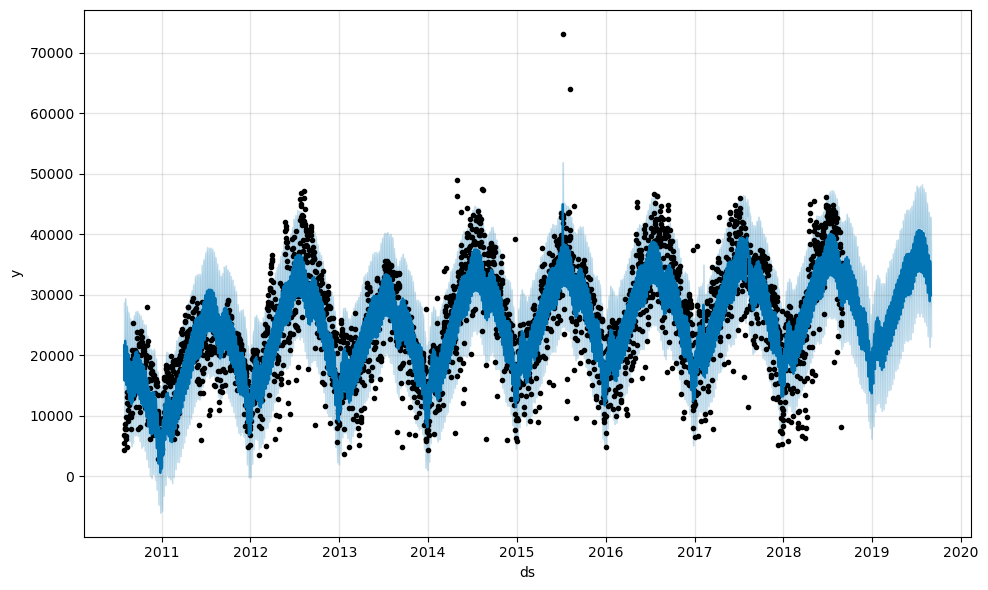

In [11]:
df_dates = forecast_model.make_future_dataframe(periods=365, include_history=True)
model_predictions = forecast_model.predict(df_dates)
plot_pred = forecast_model.plot(model_predictions)

From this plot we notice the model has done a good job of picking up the yearly seasonality.

To start working with Prophet and fit our first model, we need to perform the following steps:

- To start, we need to create another `DataFrame` with dates for the following year.

- Then, we call the `predict` method to model the future behaviour of the times series.

- Finally, we plot the prediction together with the fit on the past data.

In the plot above, the black dots correspond to the observed number of cycles hired each day (you'll notice that we don't have data beyond the beginning of 2018). The dark blue line (labeled $\hat{y}$) corresponds to the estimated number of cycles based on the fitted model. We notice it does a good job of capturing the main sources of variability in the data. Finally, the light blue lines correspond to the 80% confidence interval for the models predictions.

## Seasonality Parameters

**Seasonalities** are estimated using a partial Fourier sum.
     
The number of terms in the partial sum (called **the order**) is a parameter that determines how quickly the seasonality can change.
     
The figure below illustrates how a partial Fourier sum can approximate an aribtrary periodic signal.
     
The figure shows the first four partial sums of the Fourier series for a square wave.

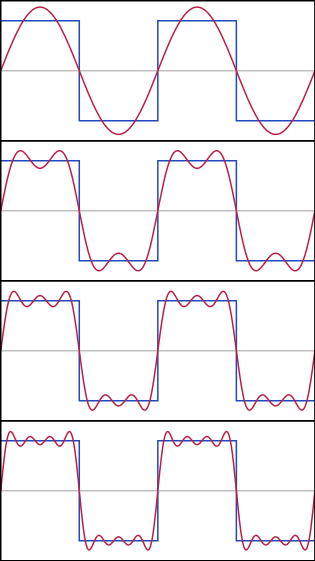 



The default values of seasonalities are often appropriate, but they can be increased when the seasonality needs to fit higher-frequency changes, and generally be less smooth. 

Please see the paper from Sean J Taylor and Benjamin Letham "Forecasting at scale" in additional_material for complete details about partial Fourier transformation.

## Seasonality Parameters


**The Fourier order** can be specified for each built-in seasonality when instantiating the model.

<br>

The higher value refers to a better fit to the training data. Specifying a **high value** of the seasonality parameter can lead to **overfitting**.

<br>

At the same time, specifying a **low value** of the seasonality parameter can lead to **underfitting** producing a model that is too general.

## Seasonality Parameters

Below, we set parameters for weekly and yearly seasonality to 3, and plot the outcome.

11:53:40 - cmdstanpy - INFO - Chain [1] start processing
11:53:40 - cmdstanpy - INFO - Chain [1] done processing


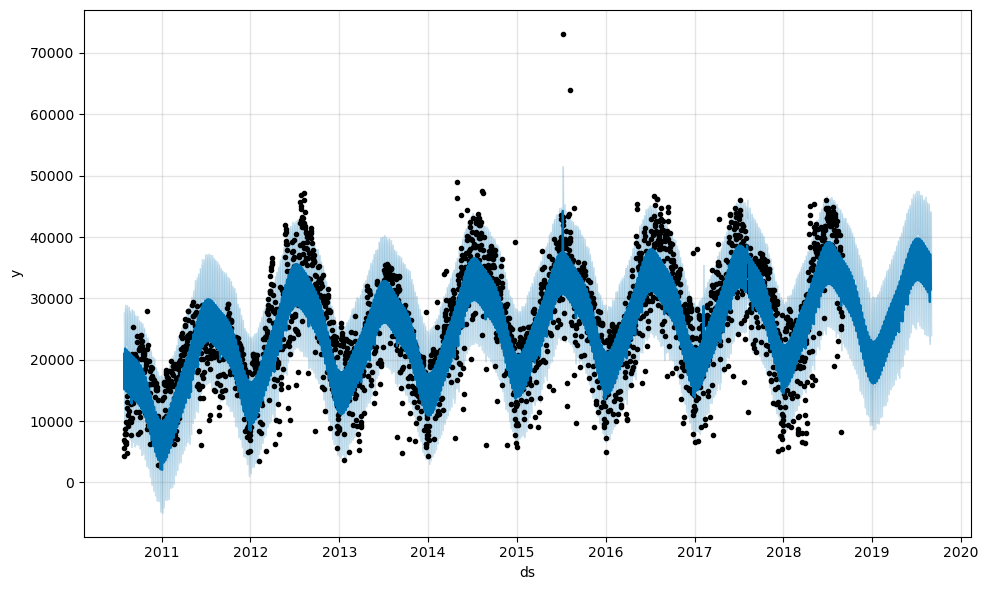

In [12]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    forecast_model = Prophet(
        growth="linear",
        weekly_seasonality=3,
        yearly_seasonality=3,
        holidays=all_holidays_strikes,
        daily_seasonality=False,
    )
    forecast_model.fit(df_data)
    df_dates = forecast_model.make_future_dataframe(periods=365, include_history=True)
    model_predictions = forecast_model.predict(df_dates)
    plot_pred = forecast_model.plot(model_predictions)

In the new plot, we can see that setting both parameters of weekly and yearly seasonality to 3 leads to a smoother fit of the model to the data than in the previous plot. The fitting model generalises well and is not affected by the outliers. 

Ploting model components using `.plot_components()` method:

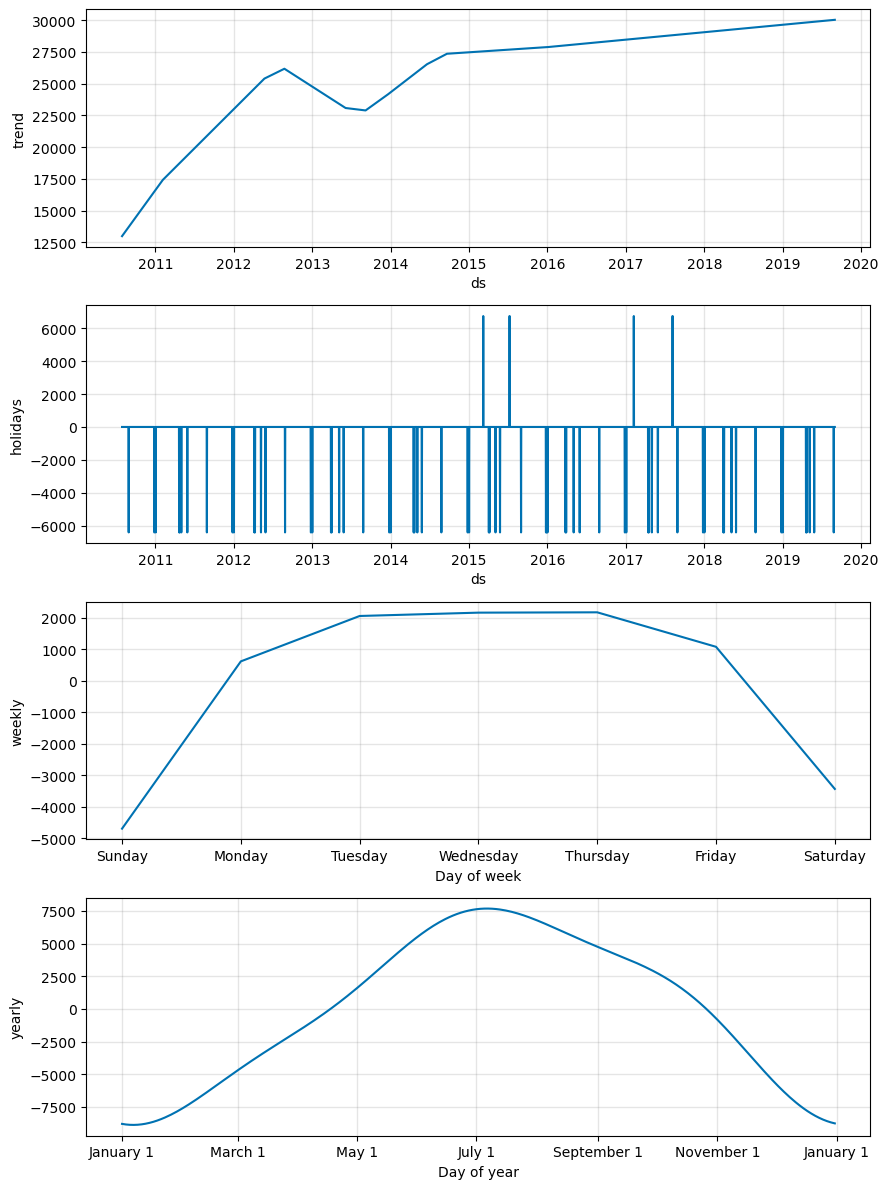

In [13]:
plot_model = forecast_model.plot_components(
    forecast_model.predict(df_dates), uncertainty=False
)


In the top panel we see the linear growth term. Recall that this term contained changepoints so that the rate of growth was allowed to vary over time. We notice that there is a large positive trend from around late 2010 until mid 2012. This is the initial adoption period. Then we notice a slight drop during 2013 before the trend stabilises. 

The second panel shows the effect of holidays and tube strikes. The holidays have negative effects whilst the tube strikes have a positive effects. This suggests that the bikes are used for commuting. 

The final two panels show the estimated yearly and weekly trends of the model. As expected there is a large increase during the summer months when the weather is more pleasant. In the case of the weekly trend, we notice that there is a large drop during weekends. This also suggests that bikes are used for commuting.

We can also study the model components - this allows us to further understand the data we study.

### Exploiting each component: Trend

Initial **trend** during 2011-2013 which levels off (there appears to be a dip in summer of 2013, its unclear why)

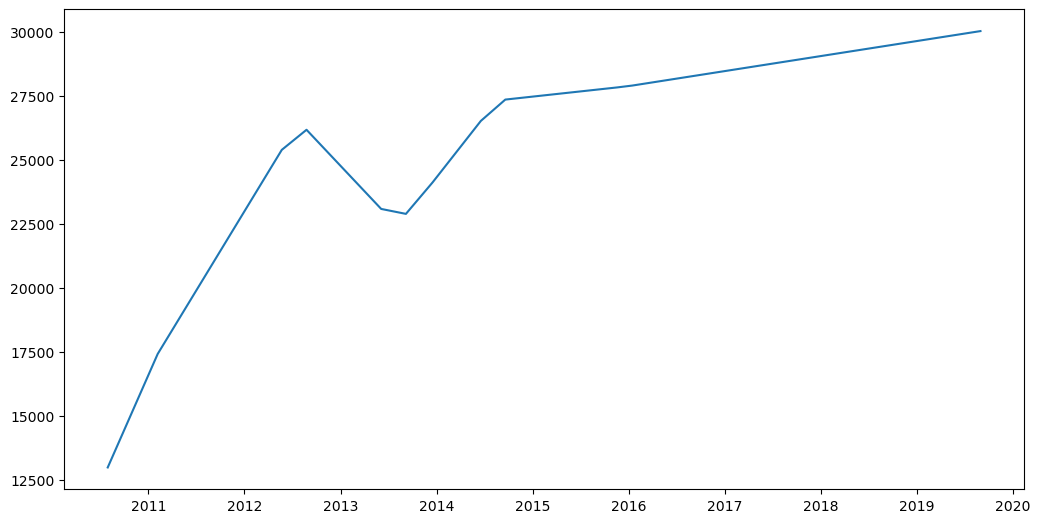

In [14]:
y = forecast_model.predict(df_dates)["trend"]
x = forecast_model.predict(df_dates)["ds"]
fig = plt.figure(figsize=(12, 6))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(x, y)
plt.show()

### Exploting each component: Yearly Seasonality

Clear **yearly seasonlity** with a peak in the summer and drop in winter 

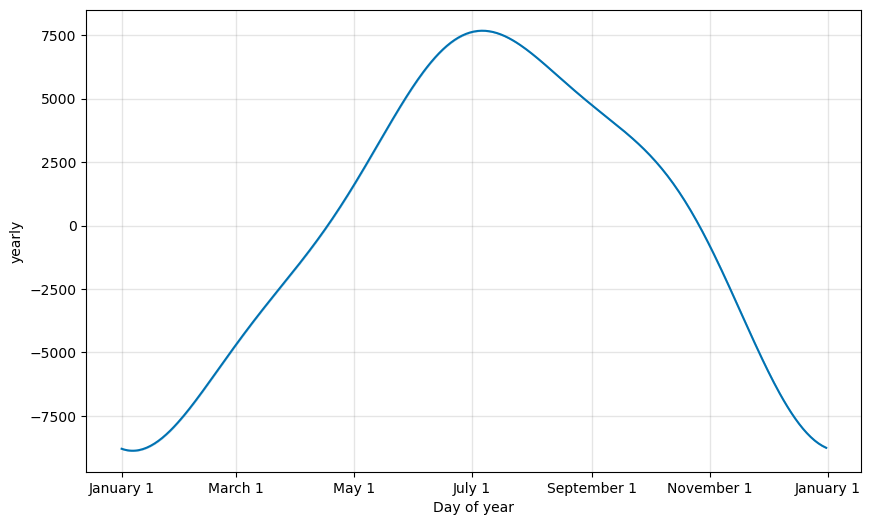

In [15]:
from prophet.plot import plot_yearly

a = plot_yearly(forecast_model)

### Exploting each component: Weekly Seasonality

Clear **weekly seasonality**, which shows that the bikes are used more on the weekdays (presumably for commuting) than on weekends:

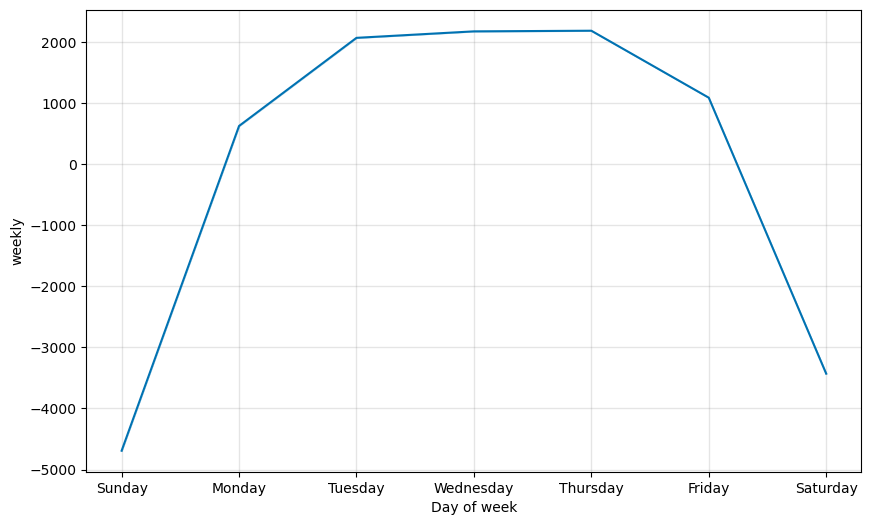

In [16]:
from prophet.plot import plot_weekly

b = plot_weekly(forecast_model)

**Note**: Finally, you may have noticed that the weekly plot appears as if it is continuous valued when we would expect it to be discrete (i.e., one value per day). Intuitively, it makes sense to fit the weekly component as an individual parameter per day of the week. This would result in a discrete weekly component, but it also requires us to estimate 7 parameters (one for each day of the week). This might not be the best way to procede.

In the case of the Prophet package, a slightly different approach is employed. Instead of estimating a parameter for each day as discussed above, we instead employ a [fourier series](https://en.wikipedia.org/wiki/Fourier_series) to model the daily effects. This effectively uses a periodic function to predict the number of cycles hired where the period is carefully adjusted to 7 days. For further details, see Section 3.2 of the [Prophet paper](http://amstat.tandfonline.com/doi/abs/10.1080/00031305.2017.1380080#.WoFjRpPFLdQ). 

##  Automatic trend changepoint detection in Prophet

- Prophet allows to detect trend changepoints 
- Initially, it specifies a large number of potential changepoints
- It then tries to minimize the number of changepoints by regularization on the magnitudes of the rate changes
- Prophet attempts to use as few of the changepoints as possible

##  Automatic trend changepoint detection in Prophet

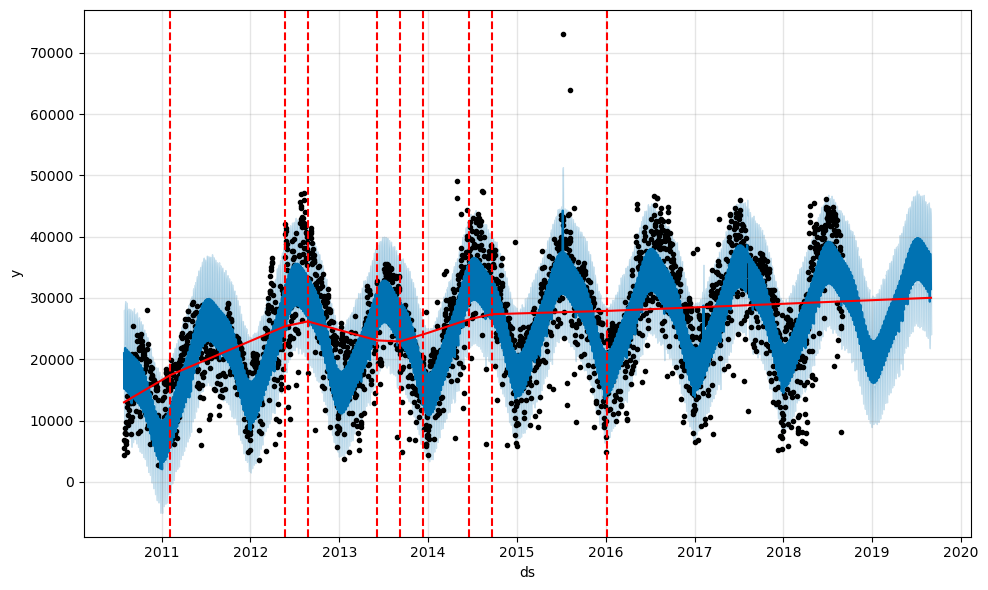

In [17]:
from prophet.plot import add_changepoints_to_plot

forecast = forecast_model.predict(df_dates)
fig = forecast_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), forecast_model, forecast)

Prophet detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change. It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) - this essentially means that Prophet has a large number of possible places where the rate can change, but will use as few of them as possible.

By default, Prophet specifies 25 potential changepoints which are uniformly placed in the first 80% of the time series. The vertical lines in this figure indicate where the potential changepoints were placed.

If you wish, rather than using automatic changepoint detection you can manually specify the locations of potential changepoints with the changepoints argument. Slope changes will then be allowed only at these points, with the same sparse regularization as before. One could, for instance, create a grid of points as is done automatically, but then augment that grid with some specific dates that are known to be likely to have changes.

## Prophet - Summary
- Open source python module developed by Facebook
- Allows us to explicitly model time-series data as consisting of a **trend**, **seasonal** and **holidays/outliers** components (all combined linearly)
- Allows for detection of **trend changepoints**

### Congratulations on fitting your forecasting model using the Prophet package!

If you are interested in learning more about the underlying models and how they are estimated, you can find many more resources on the official Prophet website:

https://research.fb.com/prophet-forecasting-at-scale/

and the official starting guide on Github:

https://facebook.github.io/prophet/docs/quick_start.html#python-api

If you more interested in the model details and estimation, you can read the paper associated with the package here:

https://peerj.com/preprints/3190.pdf